<a href="https://colab.research.google.com/github/Auzek2002/Fashion_Items_Classification_System/blob/main/Fashion_Items_Classification_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libs:

In [68]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
from tensorflow.keras import datasets,layers,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

# Installing Keras Tuner (for hp tuning)

In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.3 MB/s eta 0:00:00


In [3]:
print(tf.__version__)

2.15.0


# Loading the DataSet

In [4]:
fashion_dataSet = datasets.fashion_mnist

In [5]:
(x_train,y_train) , (x_test,y_test) = fashion_dataSet.load_data()

4422102/4422102 [==============================] - 1s 0us/step


# Exploring the DataSet

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
y_train.shape

(60000,)

In [8]:
x_test.shape

(10000, 28, 28)

In [9]:
y_test.shape

(10000,)

## **There are 60,000 training examples and 10,000 testing examples. Each image is a 28 x 28 pixel image**

# Displaying some Images

In [10]:
class_names= ['T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

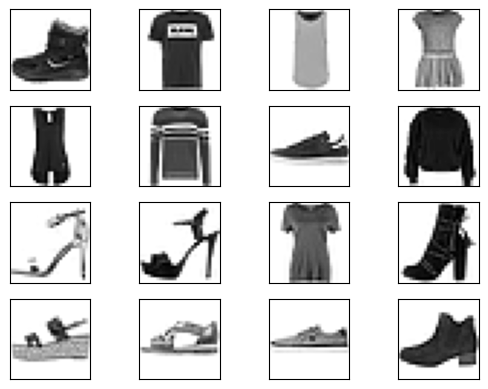

In [11]:
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train[i],cmap=plt.cm.binary)

# Normalizing the Data

In [12]:
print(f"Max pixel value is: {np.max(x_train)} and Mix pixel value is: {np.min(x_train)}")

Max pixel value is: 255 and Mix pixel value is: 0


In [13]:
#divide by 255 to normalize the data:
x_train , x_test = x_train/255.0 , x_test/255.0

# Reshaping the images

In [14]:
x_train = x_train.reshape(len(x_train),28,28,1)
x_test = x_test.reshape(len(x_test),28,28,1)

In [15]:
x_train.shape

(60000, 28, 28, 1)

In [16]:
x_test.shape

(10000, 28, 28, 1)

# Choosing the best model using keras tuner

In [17]:
def build_model(hp):
  model = Sequential([
    layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=8, max_value=1024, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5,7]),
        activation=hp.Choice('conv_1_activation',values= ['relu','selu','tanh','elu','sigmoid']),
        input_shape=(28,28,1)
    ),
    MaxPooling2D((2,2)),
    layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=8, max_value=512, step=8),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5,7]),
        activation=hp.Choice('conv_2_activation',values= ['relu','selu','tanh','elu','sigmoid'])
    ),
    MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=512, step=16),
        activation=hp.Choice('dense_1_activation',values= ['relu','selu','tanh','elu','sigmoid'])
    ),
    layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[0.0001,0.0003,0.001,0.003,0.01])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

In [18]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

<ipython-input-18-2bbfbe7dae29>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


## **Search for the best Hyperparameters**

In [19]:
tuner_search = RandomSearch(build_model,objective='val_accuracy',max_trials=10,directory='output',project_name='Fashion_items_Classification_System')

In [20]:
tuner_search.search(x_train,y_train,epochs=3,validation_split=0.1)

Trial 10 Complete [00h 00m 40s]
val_accuracy: 0.8131666779518127

Best val_accuracy So Far: 0.9073333144187927
Total elapsed time: 00h 13m 06s


## **Extracting the best model**

In [21]:
model = tuner_search.get_best_models(num_models=1)[0]


In [26]:
m = tuner_search.get_best_models(num_models=1)[0]

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 840)       8400      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 840)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 120)       907320    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 120)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 256)               7

In [27]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 840)       8400      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 840)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 120)       907320    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 120)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 256)               7

# Fitting the Model

## **With 5 Epochs:**

In [23]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=5,initial_epoch=3)

Epoch 4/5
1875/1875 [==============================] - 24s 12ms/step - loss: 0.2044 - accuracy: 0.9254 - val_loss: 0.2633 - val_accuracy: 0.9042
Epoch 5/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1711 - accuracy: 0.9378 - val_loss: 0.2522 - val_accuracy: 0.9071


## **With 20 Epochs:**

In [28]:
m.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,initial_epoch=3)

Epoch 4/20
1875/1875 [==============================] - 26s 13ms/step - loss: 0.2040 - accuracy: 0.9240 - val_loss: 0.2569 - val_accuracy: 0.9082
Epoch 5/20
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1706 - accuracy: 0.9385 - val_loss: 0.2687 - val_accuracy: 0.9041
Epoch 6/20
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1445 - accuracy: 0.9474 - val_loss: 0.2591 - val_accuracy: 0.9082
Epoch 7/20
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1210 - accuracy: 0.9568 - val_loss: 0.2677 - val_accuracy: 0.9064
Epoch 8/20
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1020 - accuracy: 0.9633 - val_loss: 0.2523 - val_accuracy: 0.9146
Epoch 9/20
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0856 - accuracy: 0.9707 - val_loss: 0.2509 - val_accuracy: 0.9147
Epoch 10/20
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0716 - accuracy: 0.9761 - val_loss: 0.2638 

In [29]:
score = model.evaluate(x_test,y_test)
score2 = m.evaluate(x_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.3665 - accuracy: 0.9085


In [30]:
print(f"Accuracy of the model with 5 epochs is: {score[1]*100:0.2f}%") #0.9010 <- old accuracy (with less neurons in each layer)
print(f"Accuracy of the model with 20 epochs is: {score2[1]*100:0.2f}%")

Accuracy of the model with 5 epochs is: 90.71%
Accuracy of the model with 20 epochs is: 90.85%


# **Making Predictions**

## **Original Image:**

In [152]:
org_img = cv.imread('/content/T_org.jpg')

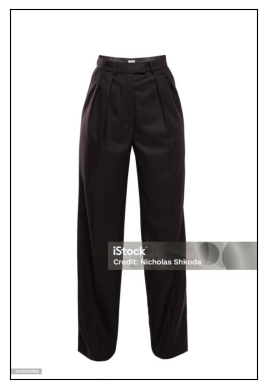

In [153]:
plt.xticks([])
plt.yticks([])
plt.imshow(org_img,cmap=plt.cm.binary)

## **Plotting the resized image**

In [154]:
img = cv.imread('/content/Trousers.jpg')

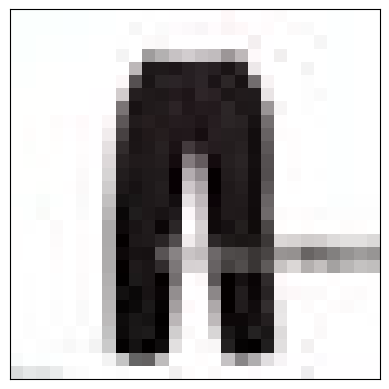

In [155]:
plt.xticks([])
plt.yticks([])
plt.imshow(img,cmap=plt.cm.binary)

In [156]:
img.shape

(28, 28, 3)

## **Making it a Grayscale image:**

In [157]:
img = cv.imread('/content/Trousers.jpg', 0)

In [158]:
img = cv.resize(img, (28, 28))

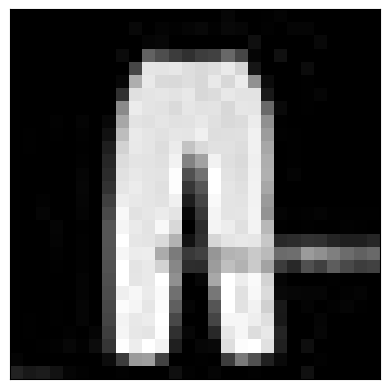

In [159]:
plt.xticks([])
plt.yticks([])
plt.imshow(img,cmap=plt.cm.binary)

In [160]:
img = img / 255.0

In [161]:
img = np.expand_dims(img, axis=0)

In [162]:
img.shape

(1, 28, 28)

In [163]:
pred = m.predict(img)

1/1 [==============================] - 0s 19ms/step


In [164]:
index = np.argmax(pred)
print(index)

1


In [166]:
print(f"predicted Fashion item is: {class_names[index]}")

predicted Fashion item is: Trouser
